<a href="https://colab.research.google.com/github/CarlosSMWolff/ParamEst-NN/blob/main/1-Trajectories_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generation of data using Monte Carlo method of quantum trajectories

## Goal

In this notebook, we populate the folder `data\trajectories` with data of photon-counting quantum trajectories simulated with Qutip.
- Training populate the folder `data\trajectories\training-trajectories` and are used to train models based in neural networks for the problem of quantum parameter estimation.
- Validation trajectories populate the folder `data\trajectories\training-trajectories` and are used to benchmark the trained models against other approaches based on Bayesian inference.

## Colab setup

If this notebook is run online in Google Colab, we download the repository from GitHub to have access to our custom functions in the `src` folder.

We must also download Qutip.

In [3]:
# Find out if this notebook is running in Google Colab
import os
isColab= 'google.colab' in str(get_ipython())

if isColab:
  print('We are running in Colab. Downloading repository.')
  ! git clone https://github.com/CarlosSMWolff/ParamEst-NN
  print('Repository downloaded.')
  ! mv ParamEst-NN/* . && rm -r ParamEst-NN
  print('Downloading Qutip.')
  ! pip install qutip


We are running in Colab. Downloading repository.
Cloning into 'ParamEst-NN'...
remote: Enumerating objects: 352, done.
remote: Counting objects: 100% (255/255), done.
remote: Compressing objects: 100% (177/177), done.
remote: Total 352 (delta 151), reused 162 (delta 71), pack-reused 97
Receiving objects: 100% (352/352), 133.04 MiB | 17.70 MiB/s, done.
Resolving deltas: 100% (181/181), done.
Repository downloaded.
mv: cannot move 'ParamEst-NN/data' to './data': Directory not empty
mv: cannot move 'ParamEst-NN/src' to './src': Directory not empty
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 36.6 MB/s eta 0:00:00


## Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import *
from qutip import *
from tqdm import tqdm
from src.quantum_tools import *

In order to benefit from parallelization, we set up the number of available CPUs for Qutip to use

In [5]:
max_cpus=19
qutip.settings.num_cpus = max_cpus

## Generation of training data for 1D case (estimation of $\Delta$)

Set up parameter to create the model of the system in Qutip

In [6]:
N=2
omega=1
gamma=1

- I will generate randomly the parameters, and only one trajectory per parameter, in order to avoid any weird information leaking.
- Number of clicks per trajectory: `njumpsMC`
- Total number of trajectories generated for training: `ndeltas`

In [7]:
# Number of clicks per trajectory
njumpsMC=48

# Number of total trajectories to generate
ndeltas = 400

# Generation of a list of random values of Delta
deltamin = 0
deltamax = 5.
delta_rand_list = deltamin + (deltamax-deltamin)*rand(ndeltas)
omega_list = omega*np.ones(ndeltas)

param_rand_list = list(zip(delta_rand_list,omega_list))

In [8]:
trajectories = np.asarray(parallel_map(generate_clicks_TLS, param_rand_list, task_kwargs=dict(njumpsMC = njumpsMC, gamma=gamma), progress_bar = True))

10.0%. Run time:   9.06s. Est. time left: 00:00:01:21
20.0%. Run time:  19.52s. Est. time left: 00:00:01:18
30.0%. Run time:  27.57s. Est. time left: 00:00:01:04
40.0%. Run time:  37.98s. Est. time left: 00:00:00:56
50.0%. Run time:  47.25s. Est. time left: 00:00:00:47
60.0%. Run time:  55.17s. Est. time left: 00:00:00:36
70.0%. Run time:  64.44s. Est. time left: 00:00:00:27
80.0%. Run time:  70.89s. Est. time left: 00:00:00:17
90.0%. Run time:  80.40s. Est. time left: 00:00:00:08
100.0%. Run time:  86.63s. Est. time left: 00:00:00:00
Total run time:  86.70s


The trajectories created have the form of time delays

In [9]:
trajectories.shape

(400, 48)

In [10]:
trajectories[0]

array([  5.3523989 ,   1.3797291 ,   1.08166421,   1.25242976,
         0.77866118,   1.2779573 ,   2.00270508,   3.30765181,
         1.23046315,  11.81163944,   8.17499333,  14.18156192,
         0.93647225,   1.68664817,   2.74743897,   2.2811057 ,
         1.68499065,   1.55774039,   1.81563378,   2.32267705,
         7.2196226 ,   0.80587631,   1.85487275,   2.7256364 ,
         1.04918763,   1.20191385,   0.87559774,   4.17687354,
         2.03455182,   0.15644974,   1.46301084,   4.63853432,
         1.89865789,   4.7110974 ,   1.10535377,   1.10355627,
         4.43880684,   1.95978836,   0.92885977,   1.30198501,
         2.45191591,   4.66886085,   4.76881362,   1.54793497,
         2.68651243,   2.38294078, 131.5724977 ,   1.48449646])

Save the trajetories into the `data/training/1D-delta` folder

In [13]:
filename = f'data/training-trajectories/1D-delta/taus-Delta-1D'
filenameDeltas = f'data/training-trajectories/1D-delta/delta_rand_list-Delta-1D'

np.save(filename,trajectories)
np.save(filenameDeltas,delta_rand_list)

## Generation of training data for 2D case (estimation of $\Delta$ and $\Omega$)

We sample the parameters randomly, and create only one trajectory per parameter

In [14]:
nparams = 400

deltamin = 0.
deltamax = 3.

omegamin =0.25
omegamax = 5.

omega_rand_list = omegamin + (omegamax-omegamin)*rand(nparams)
delta_rand_list = deltamin + (deltamax-deltamin)*rand(nparams)

In [15]:
param_rand_list = list(zip(delta_rand_list,omega_rand_list))
param_rand_array = np.array(param_rand_list)

Visualization of the distribution of parameters sampled for training

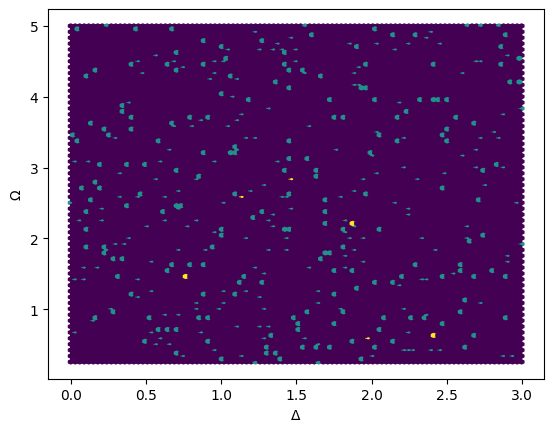

In [16]:
plt.hexbin(delta_rand_list,omega_rand_list)
plt.xlabel('$\Delta$'); plt.ylabel('$\Omega$')
plt.show()

In [17]:
trajectories = np.array(parallel_map(generate_clicks_TLS, param_rand_list,num_processes=19, progress_bar = True))

10.0%. Run time:   5.51s. Est. time left: 00:00:00:49
20.0%. Run time:  12.21s. Est. time left: 00:00:00:48
30.0%. Run time:  16.58s. Est. time left: 00:00:00:38
40.0%. Run time:  21.68s. Est. time left: 00:00:00:32
50.0%. Run time:  27.66s. Est. time left: 00:00:00:27
60.0%. Run time:  31.35s. Est. time left: 00:00:00:20
70.0%. Run time:  35.51s. Est. time left: 00:00:00:15
80.0%. Run time:  41.80s. Est. time left: 00:00:00:10
90.0%. Run time:  45.75s. Est. time left: 00:00:00:05
100.0%. Run time:  49.26s. Est. time left: 00:00:00:00
Total run time:  49.35s


Save the trajetories into the `data/training/2D-delta-omega` folder

In [18]:
# Save files to disk
filename = f'data/training-trajectories/2D-delta-omega/taus-2D'
filenameParams = f'data/training-trajectories/2D-delta-omega/param_rand_list-2D'

np.save(filename,trajectories)
np.save(filenameParams,param_rand_array)

## Generation of validation clicks for 1D case

Setup Qutip operators

In [19]:
N=2
a=destroy(N)
psi0=basis(N,0)
c_ops=[]
gamma=1
c_ops.append(np.sqrt(gamma)*a)


Notice that for the validation, we will generate many trajectories for the same value of the parameter, unlike in the training data.

- Number of points in the grid of $\Delta$ values considered for the validation: `ndelta`

- Number of trajectories for each value of the grid of parameters: `ntraj`



In [20]:
ndelta = 40
ntraj = 100

omega=1
deltaMax = 2.1
t0=0

njumpsMC=48 # to keep
njumpsSim = 60 # to actually run, we choose much larger than the number of clicks we plan to keep

deltagrid = np.linspace(0.,deltaMax,ndelta)
jumpArray = np.zeros((ndelta,ntraj,njumpsMC))

In [ ]:
for idx_delta in tqdm(range(ndelta)):
    delta = deltagrid[idx_delta]
    # Estimate the final time to have, on average, njumpsSim jumps
    tf=njumpsSim*(4*delta**2+8*omega**2+gamma**2)/(4*gamma*omega**2)
    H=delta*a.dag()*a+omega*a+omega*a.dag()
    tlist=[t0,tf] #

    ntrajRemaining = ntraj
    jumpList = []
    trajs_to_complete = [[] for i in range(ntraj)]
    trajs_completed   = []

    while ntrajRemaining > 0:
        mc=mcsolve(H,psi0,tlist,c_ops,[],ntrajRemaining,progress_bar=False)
        time_array = mc.col_times

        # Append the results into the trajectories in trajs_to_complete
        # WARNING: Appending different trajectories into a single one is only valid for the TLS, which gets reseted after each jump
        for idx, times in enumerate(time_array):
            trajs_to_complete[idx]+= list(to_time_delay(times))

        sizes = np.array([len(traj) for traj in trajs_to_complete])
        good_indexes = np.arange(ntrajRemaining)[sizes>=njumpsMC]
        bad_indexes = np.arange(ntrajRemaining)[sizes<njumpsMC]
        n_good_traj = len(good_indexes)
        ntrajRemaining = ntrajRemaining - n_good_traj

        # Trajectories with njumpsMC jumps are moved into trajs_completed
        for idx in good_indexes:
            trajs_completed += [trajs_to_complete[idx][:njumpsMC]]

        # Remove completed trajectory from trajs_to_complete
        trajs_to_complete = [trajs_to_complete[idx] for idx in bad_indexes]


    jumpArray[idx_delta,:,:] = np.asarray(trajs_completed)

 32%|███▎      | 13/40 [01:05<02:29,  5.55s/it]

In [ ]:
np.save(f"data/validation-trajectories/1D-delta/validation-trajectories-1D-delta-nsets-{ntraj}",jumpArray)
np.save(f"data/validation-trajectories/1D-delta/validation-deltas-1D-delta-nsets-{ntraj}.npy",deltagrid)

## Generation of validation clicks for 2D case

Setup Qutip operators

In [ ]:
N=2
a=destroy(N)
psi0=basis(N,0)
c_ops=[]
gamma=1
c_ops.append(np.sqrt(gamma)*a)


Notice that for the validation, we will generate many trajectories for the same value of the parameter pairs, unlike in the training data.

- Number of points in the grid of $\Delta$ values considered for the validation: `ndelta`
- Number of points in the grid of $\Omega$ values considered for the validation: `nomega`
- Number of trajectories for each value of the square grid of parameters: `ntraj`



In [ ]:
ndelta = 40
nomega = 40

ntraj = 10000
deltamin = 0.
deltamax = 2.1

omegamin =0.25
omegamax = 2.1

njumpsMC=48 # to keep
njumpsSim = 60 # to actually run, we choose much larger than the number of clicks we plan to keep


deltagrid = np.linspace(deltamin,deltamax,ndelta)
omegagrid = np.linspace(omegamin,omegamax,nomega)

def gen_param_list(array1,array2):
    return np.array(np.meshgrid(array1,array2)).T.reshape(-1,2)

param_grid = gen_param_list(deltagrid,omegagrid)
nparams = ndelta*nomega

jumpArray = np.zeros((nparams,ntraj,njumpsMC))

In [ ]:
for idx_param in tqdm(range(nparams)):
    delta = param_grid[idx_param][0]
    omega = param_grid[idx_param][1]
    tf=njumpsSim*(4*delta**2+8*omega**2+gamma**2)/(4*gamma*omega**2)
    H=delta*a.dag()*a+omega*a+omega*a.dag()
    tlist=[0.,tf] #

    ntrajRemaining = ntraj
    jumpList = []
    trajs_to_complete = [[] for i in range(ntraj)]
    trajs_completed   = []

    while ntrajRemaining > 0:
        mc=mcsolve(H,psi0,tlist,c_ops,[],ntrajRemaining,progress_bar=False)
        time_array = mc.col_times

        # Append the results into the trajectories in trajs_to_complete
        # WARNING: Appending different trajectories into a single one is only valid for the TLS, which gets reseted after each jump
        for idx, times in enumerate(time_array):
            trajs_to_complete[idx]+= list(to_time_delay(times))

        sizes = np.array([len(traj) for traj in trajs_to_complete])
        good_indexes = np.arange(ntrajRemaining)[sizes>=njumpsMC]
        bad_indexes = np.arange(ntrajRemaining)[sizes<njumpsMC]
        n_good_traj = len(good_indexes)
        ntrajRemaining = ntrajRemaining - n_good_traj

        # Trajectories with njumpsMC jumps are moved into trajs_completed
        for idx in good_indexes:
            trajs_completed += [trajs_to_complete[idx][:njumpsMC]]

        # Remove completed trajectory from trajs_to_complete
        trajs_to_complete = [trajs_to_complete[idx] for idx in bad_indexes]


    jumpArray[idx_param,:,:] = np.asarray(trajs_completed)

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [02:18<00:00,  8.69s/it]


In [ ]:
np.save(f"data/validation-trajectories/2D-delta-omega/validation-trajectories-2D-delta-omega-nsets-{ntraj}",jumpArray)
np.save(f"data/validation-trajectories/2D-delta-omega/validation-deltas-2D-delta-omega-nsets-{ntraj}.npy",param_grid)

In [ ]:
jumpArray2 = np.reshape(jumpArray,(1600,10,1000,48))

In [ ]:
for i in range(10):
    np.save(f"data/validation-trajectories/2D-delta-omega/validation-trajectories-10ktrajs-batch-{i}.npy",jumpArray2[:,i,:,:])